# Table of Contents

1. [Set up the experiment](#1-set-up-the-experiment)
   - [Import dependencies](#import-depencies)
   - [Setup computing device](#setup-computing-device)

2. [Define the model](#2-define-the-model)

3. [Fine-Tuning Pre-trained Models](#3-fine-tuning-pre-trained-models)
   - [Load Dataset from the file](#step-1-load-dataset-from-the-file)
   - [Train Test Split](#step-2-train-test-split)
   - [Plot the Data](#step-3-plot-the-data)
   - [Tokenize the Dataset](#step-4-tokenize-the-dataset)
   - [Load a Pre-trained Model](#step-5-load-a-pre-trained-model)
   - [Set Up Training Functionality](#step-6-set-up-training-functionality)
   - [Defining the custom Trainer](#step-7-defining-the-custom-trainer)
   - [Instantiate the Trainer and Run Grid Search](#step-8-instantiate-the-trainer-and-run-grid-search)
   - [Evaluate the Model](#step-9-evaluate-the-model)
   - [Try out model](#step-10-try-out-model)
   - [Saving the Fine-tuned Model](#step-11-saving-the-fine-tuned-model)

# 1. Set up the experiment

#### Import depencies

In [1]:
from transformers import pipeline
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Features, ClassLabel, Value
import os
import random
from transformers import AutoTokenizer, DataCollatorWithPadding

#### Setup computing device

In [2]:
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
# if it is not MPS, try CUDA
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else device
print(f"Using device: {device}")

2.4.1+cu121
True
Using device: cuda


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPUs

set_seed(4242)

# 2. Define the model
Sentiment Analysis is the task of classifying a given text into positive, negative, or neutral sentiments.

In this example, we will use a pre-trained model for sentiment analysis. The `pipeline` will automatically download and load a model that has been pre-trained on a large dataset to perform this task.

In [4]:
#model_name = "ncbi/MedCPT-Article-Encoder" #choose whichever u want
#model_name = "bert-base-uncased"
#model_name = "dmis-lab/biobert-v1.1"
#model_name = "microsoft/deberta-v3-base"
model_name = "ProsusAI/finbert"

**Try out the model**

In [5]:
classifier = pipeline("sentiment-analysis", model=model_name, device=device)
result = classifier(
    "The development of a recombinant polyclonal antibody therapy for COVID-19 by GigaGen represents an early-stage positive news in response to a global health crisis. However, such initiatives often come with high risk and uncertainty given the complexity and time required for clinical trials and approval processes. Additionally, competition in the COVID-19 treatment space is intense, with many companies pursuing similar therapies. These factors make it essential to remain cautious, monitoring further developments and data closely."
)

print(f"Sentiment Analysis Result: {result}")

Sentiment Analysis Result: [{'label': 'neutral', 'score': 0.7638072371482849}]


# 3. Fine-Tuning Pre-trained Models
While the pre-trained models provided by Hugging Face are powerful, you may want to fine-tune them for a specific task or dataset.

Fine-tuning involves taking a pre-trained model and training it further on your own data. This can improve the model’s performance for specific use cases.

### Step 1: Load Dataset from the file

**Set the file path**

In [6]:
data_file_path = "../data/aprocessed/finetuning_3_labels_topic_pruned.csv"
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"The file {data_file_path} does not exist!")

FileNotFoundError: The file ../data/aprocessed/finetuning_3_labels_topic_pruned.csv does not exist!

***ALTERNATIVE FOR COLLAB***

In [7]:
data_file_path = "finetuning_3_labels_topic_pruned.csv"
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"The file {data_file_path} does not exist!")

**Load the data with proper labels**

In [8]:
# Define the features
features = Features(
    {
        "text": Value("string"),
        "labels": ClassLabel(names=["0.0", "1.0", "2.0"]),
    }
)

# Load the dataset with the specified features
dataset = load_dataset(
    "csv",
    data_files=data_file_path,
    features=features,
)

### Step 2: Train Test Split

**Add a columns "id" with a unique row id for later use**

In [9]:
dataset["train"] = dataset["train"].add_column("id", range(len(dataset["train"])))

Example data point

In [10]:
print(dataset)
print(dataset["train"][1])

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4020
    })
})
{'text': 'GigaGen to Present at the Inaugural LifeSci Partners Private Company Virtual Summer Symposium SOUTH SAN FRANCISCO, Calif., July  29, 2020  (GLOBE NEWSWIRE) -- GigaGen Inc., a biotechnology company advancing transformative antibody drugs for infectious diseases, transplant rejection and checkpoint resistant cancers, today announced that it will participate in the LifeSci Partners Private Company Virtual Summer Symposium, taking place on August 4-5, 2020.', 'labels': 1, 'id': 1}


**Split the data**

In [11]:
from sklearn.model_selection import train_test_split

labels = np.array(dataset["train"]["labels"])
indices = np.arange(len(labels))

train_indices, test_indices = train_test_split(
    indices,
    test_size=0.1,
    stratify=labels,
    random_state=42,  # Ensures reproducibility
)

# Create stratified train and test datasets, remember its a pandas dataframe
train_dataset = dataset["train"].select(train_indices)
test_dataset = dataset["train"].select(test_indices)

### Step 3: Plot the Data

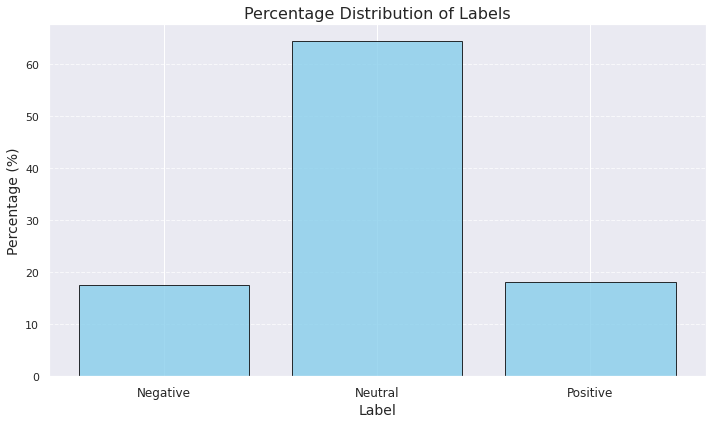

In [12]:
labels = np.array(dataset["train"]["labels"])
label_counts = np.bincount(labels)
label_percentages = label_counts / label_counts.sum() * 100  # Convert counts to percentages
label_names = ["Negative", "Neutral", "Positive"]

# Apply Seaborn style
sns.set()

plt.figure(figsize=(10, 6))
plt.bar(range(len(label_percentages)), label_percentages, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Label", fontsize=14, fontweight='normal')
plt.ylabel("Percentage (%)", fontsize=14, fontweight='normal')
plt.title("Percentage Distribution of Labels", fontsize=16, fontweight='normal')
plt.xticks(range(len(label_percentages)), label_names, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

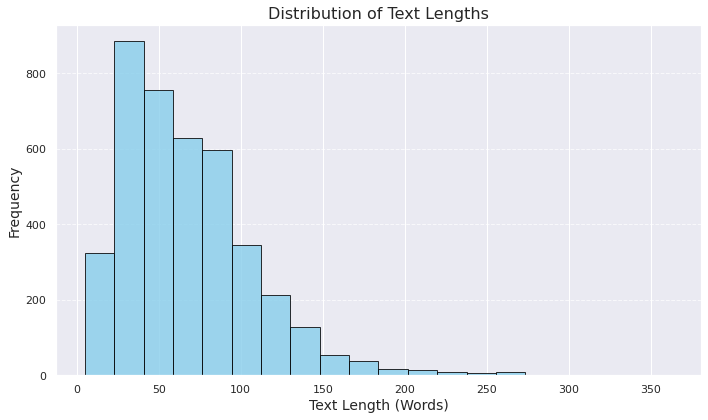

In [13]:
text_lengths = [len(text.split()) for text in dataset["train"]["text"]]

sns.set()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Text Length (Words)", fontsize=14, fontweight='normal')
plt.ylabel("Frequency", fontsize=14, fontweight='normal')
plt.title("Distribution of Text Lengths", fontsize=16, fontweight='normal')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Step 4: Tokenize the Dataset
The dataset needs to be tokenized before it can be fed into the model. Tokenization converts the text data into numerical format (tokens) that the model can process.

We'll use the `AutoTokenizer` class from HuggingFace to tokenize the data. The `AutoTokenizer` class automatically selects the appropriate tokenizer for the model based on the `model_name`.

Tokenization or transformation of the dataset can be done using the `map` method, which applies a function to all the elements of the dataset. This is easily done by defining a function that tokenizes the text data and then applying it to the dataset. When `batched=True`, the function will be applied to batches of data, which can improve performance by applying the function in parallel.

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, padding="max_length", max_length=512
)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Tokenized test set sctructure

In [15]:
tokenized_test

Dataset({
    features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 402
})

### Step 5: Load a Pre-trained Model
Now that the data is tokenized, we'll load a pre-trained model that we'll fine-tune for sentiment classification.

We need to import `AutoModelForSequenceClassification` for that. The key feature of this class is that it adds a classification head on top of the pre-trained transformer model to allow it to classify sequences into one or more categories (e.g., positive/negative sentiment, spam/ham, etc.). The `from_pretrained` method loads the pre-trained model with the specified configuration. The `num_labels` parameter specifies the number of labels in the classification task (binary in this case).

In [36]:
import torch
import torch.nn as nn
from transformers import AutoModel
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput

class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels=3, hidden_sizes=[512, 512, 256]):
        super().__init__()
        self.num_labels = num_labels
        self.base_model = AutoModel.from_pretrained(model_name)  # Changed from backbone to base_model
        hidden_dim = self.base_model.config.hidden_size
        
        layers = []
        prev_dim = hidden_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            prev_dim = h
        
        layers.append(nn.Linear(prev_dim, num_labels))
        self.classifier = nn.Sequential(*layers)
        
        # Proper configuration setup
        self.config = self.base_model.config
        self.config.num_labels = num_labels
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        
        outputs = self.base_model(  # Changed from backbone to base_model
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output
            
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions if output_attentions else None,
        )

### Step 6: Set Up Training Functionality

**Setup the metrics calculation**

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", labels=[0, 1, 2]
    )
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

**Compute class weights to counter class inbalance**

In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(dataset["train"]["labels"]),
    y=dataset["train"]["labels"],
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([1.9034, 0.5182, 1.8356])


**Define the Loss function**

In [19]:
import torch.nn as nn
import torch.nn.functional as F


# Define custom loss function
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.class_weights = class_weights

    def forward(self, logits, labels):
        return F.cross_entropy(logits, labels, weight=self.class_weights)

**Define Gradual unfreezing**

In [20]:
def gradually_unfreeze(model, freeze_epoch, total_epochs):
    total_layers = len(model.base_model.encoder.layer)
    layers_to_unfreeze = int((freeze_epoch / total_epochs) * total_layers)
    layers_to_unfreeze = min(layers_to_unfreeze, total_layers)

    # Unfreeze the layers progressively from the bottom (earlier layers)
    for i in range(total_layers - layers_to_unfreeze, total_layers):
        for param in model.base_model.encoder.layer[i].parameters():
            param.requires_grad = True

    print(f"Epoch {freeze_epoch}: Unfreezing {layers_to_unfreeze}/{total_layers} layers.")


def freeze_all_layers(model):
    # Freeze all transformer layers except the final classification layer
    for param in model.base_model.parameters():
        param.requires_grad = False

    # Unfreeze the final classifier layer
    for param in model.classifier.parameters():
        param.requires_grad = True

**System metric tracking**

In [21]:
# Helper functions for tracking system metrics during training
import time
import psutil
import subprocess

def get_gpu_memory_usage():
    # Run nvidia-smi to get both used and total memory ! MIGHT CAUSE CODE BREAK ON iOS MACHINES ! 
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=memory.used,memory.total", "--format=csv,nounits,noheader"],
        stdout=subprocess.PIPE
    )
    used_memory, total_memory = result.stdout.decode("utf-8").strip().split("\n")[0].split(", ")

    return int(used_memory), int(total_memory)

# Pass the model type as a string
def track_performance(model_type):
    process = psutil.Process(os.getpid())

    start_time = time.time()

    trainer.train() # assumes trainer is already defined

    # Track memory and time
    memory_usage = process.memory_info().rss / (1024 * 1024)
    gpu_memory_used, gpu_memory_total = get_gpu_memory_usage()
    end_time = time.time()

    time_elapsed = end_time - start_time

    print(f"{model_type} - Time taken: {time_elapsed:.2f} seconds")
    print(f"{model_type} - CPU Memory usage: {memory_usage:.2f} MB")
    print(f"{model_type} - GPU Memory usage: {gpu_memory_used} MB / {gpu_memory_total} MB")

### Step 7: Defining the custom Trainer
Hugging Face provides the Trainer class to help with the training and fine-tuning of models. We need to set up the trainer by providing the model, training arguments, and the datasets.

Here, we define a custom wrapper over that trainer in order to apply the weights to the loss and handle the use of custom optimizers with learning rate scheduling.

**Defining the Trainer Class**

In [22]:
from transformers import Trainer, TrainingArguments
from torch.optim.lr_scheduler import OneCycleLR

# Define custom trainer
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights, optimizer=None, num_training_steps=None, total_epochs=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.optimizer = optimizer
        self.num_training_steps = num_training_steps
        self.total_epochs = total_epochs
        self.freeze_epoch = 0

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # Added **kwargs to handle required arguments unused by our loss
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move class_weights to the same device as logits
        loss_fct = WeightedCrossEntropyLoss(self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

    def create_scheduler(self, num_training_steps=None, optimizer=None): # Slanted Triangular Learning Rate
        if self.lr_scheduler is None:
            num_training_steps = self.num_training_steps or (
                len(self.train_dataset) // self.args.per_device_train_batch_size * self.args.num_train_epochs
            )
            self.lr_scheduler = OneCycleLR(
                optimizer=optimizer,
                max_lr=1e-4,  # Peak learning rate
                total_steps=num_training_steps,
                pct_start=0.2,  # Fraction of steps to increase LR
                anneal_strategy='cos',  # Linear decrease after peak
            )
        return self.lr_scheduler

    def on_epoch_begin(self, args, state, control, **kwargs):
        # Gradually unfreeze layers based on the current epoch
        gradually_unfreeze(self.model, self.freeze_epoch, self.total_epochs)
        self.freeze_epoch += 1

**Defining the training callback**

In [23]:
from transformers import TrainerCallback

class TrainingMonitorCallback(TrainerCallback):
    """ Tracks the learning rate and gradual unfreezing"""
    def __init__(self, model, total_layers, plot_save_path=None):
        super().__init__()
        self.model = model
        self.total_layers = total_layers
        self.lrs = []
        self.plot_save_path = plot_save_path

    def on_epoch_begin(self, args, state, control, **kwargs):
        """Called at the beginning of each epoch"""
        # Calculate how many layers are unfrozen based on the current epoch
        gradually_unfreeze(self.model, state.epoch, args.num_train_epochs)
        unfrozen_layers = sum(
            1 for i in range(self.total_layers)
            if any(param.requires_grad for param in self.model.base_model.encoder.layer[i].parameters())
        )

        # Print the number of unfrozen layers at the start of the epoch
        print(f"Epoch {state.epoch}: {unfrozen_layers}/{self.total_layers} encoder layers are unfrozen.")

    def on_step_end(self, args, state, control, optimizer, **kwargs):
        """Called at the end of each training step"""
        if optimizer is not None:  # Safety check
            lr = optimizer.param_groups[0]['lr']
            self.lrs.append(lr)
            
    def plot_learning_rate(self):
        """Plot the learning rate history"""
        if len(self.lrs) > 0:
            sns.set()
            plt.figure(figsize=(10, 6))
            plt.plot(self.lrs, color='skyblue', linewidth=2)
            plt.title("Learning Rate over Training Steps", fontsize=16, fontweight='normal')
            plt.xlabel("Training Step", fontsize=14, fontweight='normal')
            plt.ylabel("Learning Rate", fontsize=14, fontweight='normal')
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            plt.grid(axis='both', linestyle='--', alpha=0.7)
            plt.tight_layout()
            if self.plot_save_path:
                plt.savefig(self.plot_save_path)
            else:
                plt.show()

### Step 8: Instantiate the Trainer and Run Grid Search
After adjusting the parameters in the grid search brackets, run the following cell to execute fine-tuning:

In [37]:
from itertools import product

# Define hyperparameters to search over
learning_rates = [1e-5]
batch_sizes = [8]
num_epochs = [20]
weight_decays = [0.01]

# Create a grid of hyperparameter combinations
param_grid = list(product(learning_rates, batch_sizes, num_epochs, weight_decays))

best_model = None
best_f1 = 0
best_params = None

# Iterate over all combinations
for lr, batch_size, num_epochs, wd in param_grid:
    model = CustomClassifier(model_name, num_labels=3).to(device)
    tracker = TrainingMonitorCallback(model, total_layers=len(model.base_model.encoder.layer))
    # Create the custom optimizer
    custom_optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    # Create the TrainingArguments with the current hyperparameters
    training_args = TrainingArguments(
        output_dir="./results",  # Output directory
        eval_strategy="epoch",  # Evaluate after each epoch
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,  # Batch size for training
        per_device_eval_batch_size=batch_size,  # Batch size for evaluation
        gradient_accumulation_steps=2,  # Gradient accumulation steps FOR MEMORY EFFICIENCY
        num_train_epochs=num_epochs,  # Number of epochs
        load_best_model_at_end=True,  # Load the best model at the end
        metric_for_best_model="f1",  # Use F1 score to select the best model
        save_total_limit=1,  # Limit the total amount of checkpoints
        report_to="none",  # Disable all integrations, including wandb
    )

    # Calculate number of training steps
    num_training_steps = (
        (len(tokenized_train) // training_args.per_device_train_batch_size)
        // training_args.gradient_accumulation_steps
    ) * training_args.num_train_epochs

    # Create the Trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        class_weights=class_weights,
        data_collator=data_collator,
        optimizer=custom_optimizer,
        num_training_steps=num_training_steps,
        callbacks=[tracker],
        total_epochs=training_args.num_train_epochs,
    )
    
    trainer.optimizer = custom_optimizer
    
    freeze_all_layers(model)
    #trainer.train()
    track_performance(model_name) # if this breaks due to nvidia issues, use trainer.train() instead

    # Evaluate and get the F1 score
    f1_score = trainer.evaluate()["eval_f1"]

    # Store the best model and parameters based on F1 score
    if f1_score > best_f1:
        best_f1 = f1_score
        best_model = trainer.model
        best_params = (lr, batch_size, num_epochs, wd)
        print("new best:", best_params)
        

# Output the best parameters and model
print(f"Best F1 score: {best_f1}")
print(f"Best hyperparameters: learning rate={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]}, weight decay={best_params[3]}")


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch 0: Unfreezing 0/12 layers.
Epoch 0: 0/12 encoder layers are unfrozen.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,1.091521,0.606965,0.518163,0.459750,0.606965
2,1.093000,1.079868,0.562189,0.545643,0.544460,0.562189
4,1.074000,1.064254,0.606965,0.586156,0.573920,0.606965


/home4/s5173019/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0.9977924944812362: Unfreezing 0/12 layers.
Epoch 0.9977924944812362: 0/12 encoder layers are unfrozen.
Epoch 2.0: Unfreezing 1/12 layers.
Epoch 2.0: 1/12 encoder layers are unfrozen.
Epoch 2.997792494481236: Unfreezing 1/12 layers.
Epoch 2.997792494481236: 1/12 encoder layers are unfrozen.
Epoch 4.0: Unfreezing 2/12 layers.
Epoch 4.0: 2/12 encoder layers are unfrozen.


SafetensorError: Error while serializing: IoError(Os { code: 7, kind: ArgumentListTooLong, message: "Argument list too long" })

### Step 9: Evaluate the Model
After training, we can evaluate the model’s performance on the test set.

In [30]:
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

Evaluation Results: {'eval_loss': 2.9962565898895264, 'eval_accuracy': 0.6243781094527363, 'eval_f1': 0.5936964040197871, 'eval_precision': 0.5790450551882753, 'eval_recall': 0.6243781094527363, 'eval_runtime': 3.1389, 'eval_samples_per_second': 128.07, 'eval_steps_per_second': 16.248, 'epoch': 19.955849889624723}


Visualize the cosine Slanted Triangular Learning Rate

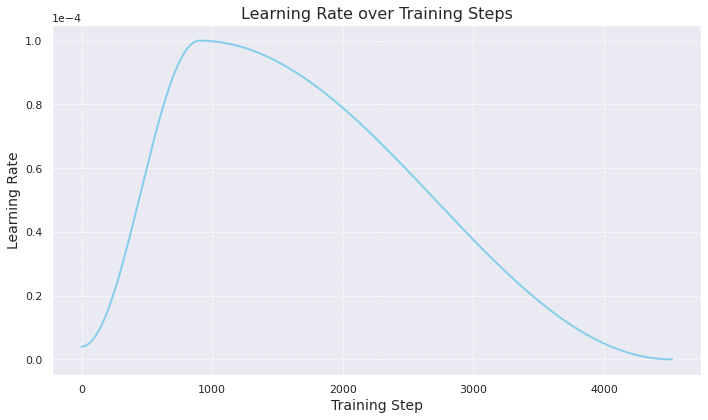

In [31]:
tracker.plot_learning_rate()

**Generate Model Predictions**

In [32]:
# generate predictions
#tokenized_dataset = dataset['train'].map(tokenize_function, batched=True) # uncomment if want to test on the whole dataset
predictions_raw = trainer.predict(tokenized_test)
predictions = np.argmax(predictions_raw.predictions, axis=1)

**Calculate Gross Profit**

In [34]:
import pandas as pd
import random

class ProfitEvaluator:
    def __init__(self, model_predictions, test_file, test_size=0.15, random_state=42):
        self.predictions = model_predictions
        self.base_dir = os.getcwd()
        self.price_file = "news+prices-new-2.csv" # file with pricing information
        self.test_file = test_file # file used to train the network
        self.test_size = test_size
        self.random_state = random_state

        self.eval_profit_dataset = pd.read_csv(self.price_file)
        self.test_data = pd.read_csv(self.test_file)

        self.test_indices = self.test_data.index.tolist()

    
    def calculate_price_change(self, current_index):
        """ Calculates the price change for the current index """
        buy_in = self.eval_profit_dataset.loc[current_index, "buy_in_price"]
        sell = self.eval_profit_dataset.loc[current_index, "close"]
        increase_decrease = sell / buy_in - 1
        return(increase_decrease)


    def calculate_profit(self):
        total_profit = 0
        test_indices_copy = self.test_indices.copy()
        prediction_transformation = {
            0: -1, # Short sell
            1: 0, # Do nothing
            2: 1, # Long buy
        }

        for prediction in self.predictions:
            if test_indices_copy:  # Check if there are still indices to process
                current_index = test_indices_copy[0]  # Get the current index
                price_move = self.calculate_price_change(current_index)
                price_move *= prediction_transformation[prediction] # Apply the prediction transformation
                total_profit += price_move

                # Remove the processed index from the list
                test_indices_copy.pop(0)
            else:
                print("No more indices left to process!")
                break

        print(f"\nFinal Total Profit: {total_profit}")
        print(f"Remaining rows in eval dataset: {len(test_indices_copy)}")

print(len(predictions))

evaluator = ProfitEvaluator(predictions, data_file_path)
evaluator.calculate_profit()

402

Final Total Profit: 1.5759755226737713
Remaining rows in eval dataset: 3618


**Generate the ROC curves**

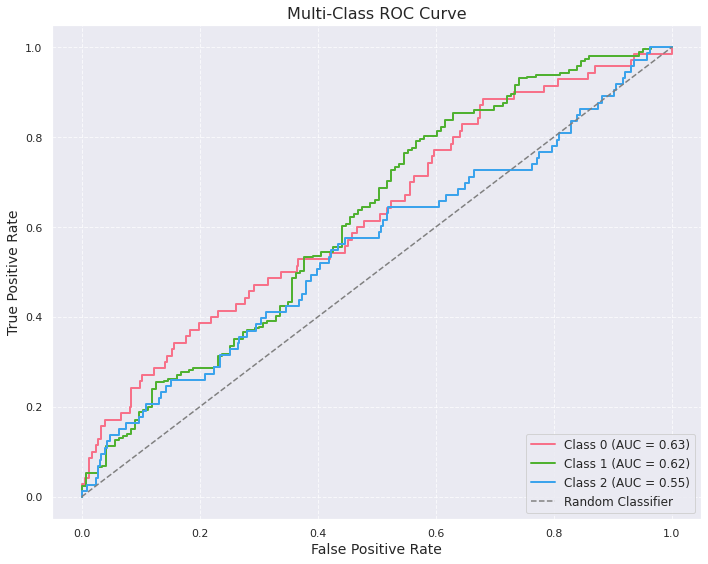

In [35]:
from sklearn.metrics import roc_curve, auc
from torch.nn import functional as F
from sklearn.preprocessing import label_binarize

logits = torch.tensor(predictions_raw.predictions)

# Apply softmax to logits to get probabilities for each class
probabilities = F.softmax(logits, dim=-1)

true_labels = predictions_raw.label_ids
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2])

sns.set()

plt.figure(figsize=(10, 8))

n_classes = true_labels_bin.shape[1] 
colors = sns.color_palette("husl", n_classes)  

for i in range(n_classes):
    # For each class, calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], probabilities[:, i].cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.5, label='Random Classifier')


plt.xlabel("False Positive Rate", fontsize=14, fontweight='normal')
plt.ylabel("True Positive Rate", fontsize=14, fontweight='normal')
plt.title("Multi-Class ROC Curve", fontsize=16, fontweight='normal')
plt.legend(loc="lower right", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Step 10: Try out model

In [ ]:
input_string = "BioVie Announces Alignment with FDA on Clinical Trial to Assess Bezisterim in Parkinson’s Disease,SUNRISE-PD to evaluate the effect of bezisterim (NE3107) on motor and non-motor symptoms in ~60 patients with Parkinson’s disease who are naïve to carbidopa/levodopa,SUNRISE-PD to evaluate the effect of bezisterim (NE3107) on motor and non-motor symptoms in ~60 patients with Parkinson’s disease who are naïve to carbidopa/levodopa"

# Tokenize the input string
inputs = tokenizer(input_string, return_tensors="pt").to(device)

with torch.no_grad():  # Disable gradient computation since we're just doing inference
    outputs = model(**inputs)
    logits = outputs.logits
print(logits)
predicted_label = torch.argmax(logits, dim=1).item()


print(f"Predicted label: {predicted_label}")

### Step 11: Saving the Fine-tuned Model
After training, it is often useful to save the fine-tuned model, so you can use it later without needing to re-train it.

In [ ]:
model.push_to_hub(
    f"akseljoonas/MedCPT-Article-Encoder-finetuned-{eval_results['f1']:.3f}"
)
tokenizer.push_to_hub(
    f"akseljoonas/MedCPT-Article-Encoder-finetuned-{eval_results['f1']:.3f}"
)